# Discovery dos dados

Neste notebook meu objetivo é fazer um check de sanidade das informações. Eu pesquisei e o dataset é bem visto na comunidade. 
Meu objetivo aqui, até pelo tempo que tenho disponível para esse projeto, não vai ser me aprofundar e validar todas as informações aqui presentes, mas neste notebook eu quero dar uma olhada geral pra ver se o que tem aqui faz sentido. E o que não fizer sentido eu vou tentar entender um pouco melhor.

In [1]:
# Preciso fazer a config abaixo para que os imports funcionem corretamente

import os
from pathlib import Path
import utils as fxns

# Caminho absoluto da raiz do projeto
project_root = Path.cwd().parent  # se o notebook está em /notebooks
os.chdir(project_root)

print("Diretório atual:", Path.cwd())

Diretório atual: b:\projetos\f1_analytics


In [2]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
from src.modules.db_reader import DbReader
from src.data_viz.plotter import Plotter
f1_db = DbReader()
plotter = Plotter()

# Olhada geral nos dados de qualificação:

In [3]:
df_quali = f1_db.run_query_file("data/db_queries/qualify_report.sql").drop_duplicates()

In [4]:
df_quali

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_nationality,constructor_name,constructor_nationality,position,q1_time,q2_time,q3_time
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HAM,Lewis,Hamilton,British,McLaren,British,1,1:26.572,1:25.187,1:26.714
1,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,KUB,Robert,Kubica,Polish,BMW Sauber,German,2,1:26.103,1:25.315,1:26.869
2,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,KOV,Heikki,Kovalainen,Finnish,McLaren,British,3,1:25.664,1:25.452,1:27.079
3,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,MAS,Felipe,Massa,Brazilian,Ferrari,Italian,4,1:25.994,1:25.691,1:27.178
4,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HEI,Nick,Heidfeld,German,BMW Sauber,German,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10489,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,ALB,Alexander,Albon,Thai,Williams,British,16,1:23.821,\N,\N
10490,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,ZHO,Guanyu,Zhou,Chinese,Sauber,Swiss,17,1:23.880,\N,\N
10491,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,HAM,Lewis,Hamilton,British,Mercedes,German,18,1:23.887,\N,\N
10492,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,COL,Franco,Colapinto,Argentinian,Williams,British,19,1:23.912,\N,\N


In [5]:
df_poles = df_quali[df_quali["position"] == 1].copy()

In [6]:
df_poles

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_nationality,constructor_name,constructor_nationality,position,q1_time,q2_time,q3_time
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HAM,Lewis,Hamilton,British,McLaren,British,1,1:26.572,1:25.187,1:26.714
22,Malaysian Grand Prix,2008,2008-03-23,Sepang International Circuit,Malaysia,MAS,Felipe,Massa,Brazilian,Ferrari,Italian,1,1:35.347,1:34.412,1:35.748
44,Bahrain Grand Prix,2008,2008-04-06,Bahrain International Circuit,Bahrain,KUB,Robert,Kubica,Polish,BMW Sauber,German,1,1:32.893,1:31.745,1:33.096
66,Spanish Grand Prix,2008,2008-04-27,Circuit de Barcelona-Catalunya,Spain,RAI,Kimi,Räikkönen,Finnish,Ferrari,Italian,1,1:20.701,1:20.784,1:21.813
88,Turkish Grand Prix,2008,2008-05-11,Istanbul Park,Turkey,MAS,Felipe,Massa,Brazilian,Ferrari,Italian,1,1:25.994,1:26.192,1:27.617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10394,Mexico City Grand Prix,2024,2024-10-27,Autódromo Hermanos Rodríguez,Mexico,SAI,Carlos,Sainz,Spanish,Ferrari,Italian,1,1:16.778,1:16.515,1:15.946
10414,São Paulo Grand Prix,2024,2024-11-03,Autódromo José Carlos Pace,Brazil,NOR,Lando,Norris,British,McLaren,British,1,1:30.944,1:24.844,1:23.405
10434,Las Vegas Grand Prix,2024,2024-11-23,Las Vegas Strip Street Circuit,United States,RUS,George,Russell,British,Mercedes,German,1,1:33.186,1:32.779,1:32.312
10454,Qatar Grand Prix,2024,2024-12-01,Losail International Circuit,Qatar,VER,Max,Verstappen,Dutch,Red Bull,Austrian,1,1:21.579,1:20.687,1:20.520


In [7]:
df_count_pole_por_piloto = df_poles.groupby("driver_surname").size().reset_index(name="pole_count")

In [8]:
df_count_pole_por_piloto

,driver_surname,pole_count
0,Alesi,1
1,Alonso,23
2,Barrichello,10
3,Berger,4
4,Bottas,19
5,Button,8
6,Coulthard,6
7,Fisichella,4
8,Frentzen,1
9,Hamilton,107


b:\projetos\f1_analytics\src\data_viz\plotter.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
b:\projetos\f1_analytics\src\data_viz\plotter.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha=ha)


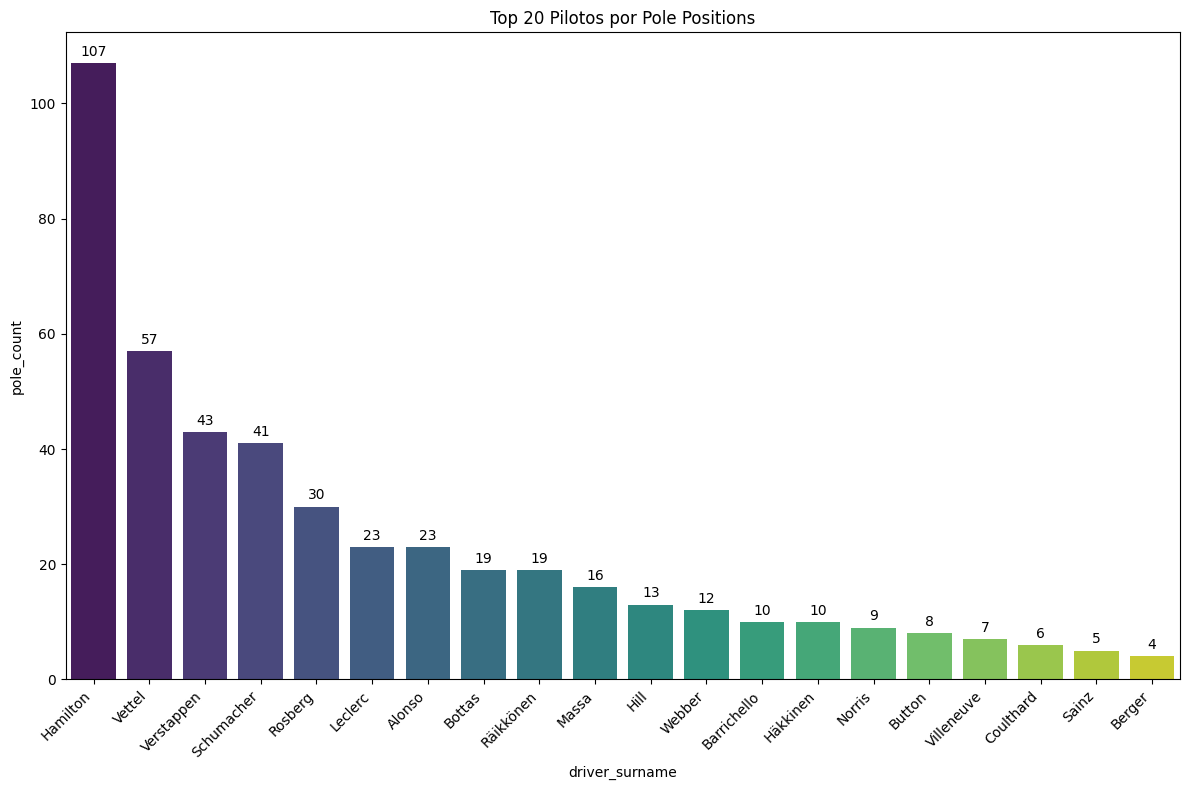

In [9]:
plotter.barplot(
    df=df_count_pole_por_piloto.sort_values("pole_count", ascending=False).head(20),
    x="driver_surname",
    y="pole_count",
    palette="viridis",
    figsize=(12, 8),
    title="Top 20 Pilotos por Pole Positions"
)

Vendo o gráfico acima, parece que o dataset não é 100% perfeito, o Schumacher teria mais poles do que o indicado, e o Hamilton por exemplo não tem 107, e sim 104.

## Vou tentar analisar a integralidade dos dados, e o quão errado pode estar:

### Primeiro vou ver a quantidade de dados por ano:

In [10]:
df_quali

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_nationality,constructor_name,constructor_nationality,position,q1_time,q2_time,q3_time
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HAM,Lewis,Hamilton,British,McLaren,British,1,1:26.572,1:25.187,1:26.714
1,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,KUB,Robert,Kubica,Polish,BMW Sauber,German,2,1:26.103,1:25.315,1:26.869
2,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,KOV,Heikki,Kovalainen,Finnish,McLaren,British,3,1:25.664,1:25.452,1:27.079
3,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,MAS,Felipe,Massa,Brazilian,Ferrari,Italian,4,1:25.994,1:25.691,1:27.178
4,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HEI,Nick,Heidfeld,German,BMW Sauber,German,5,1:25.960,1:25.518,1:27.236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10489,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,ALB,Alexander,Albon,Thai,Williams,British,16,1:23.821,\N,\N
10490,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,ZHO,Guanyu,Zhou,Chinese,Sauber,Swiss,17,1:23.880,\N,\N
10491,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,HAM,Lewis,Hamilton,British,Mercedes,German,18,1:23.887,\N,\N
10492,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,COL,Franco,Colapinto,Argentinian,Williams,British,19,1:23.912,\N,\N


In [11]:
df_eventos_quali_por_ano = df_quali[["year", "race_name"]].drop_duplicates().sort_values("year")

b:\projetos\f1_analytics\src\data_viz\plotter.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
b:\projetos\f1_analytics\src\data_viz\plotter.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha=ha)


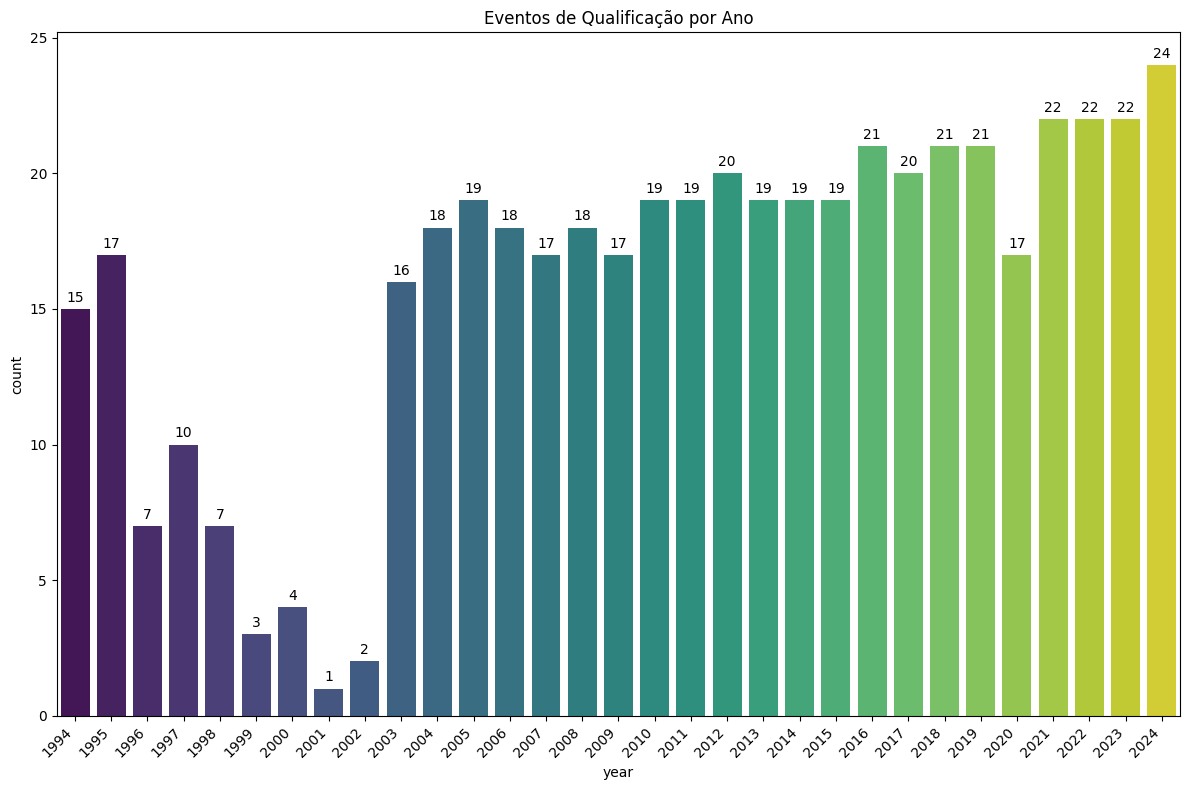

In [12]:
plotter.barplot(
    df=df_eventos_quali_por_ano,
    x="year",              # eixo X
    groupby="year",         # agrupa por ano
    count_name="count",     # nome da contagem
    palette="viridis",
    figsize=(12, 8),
    title="Eventos de Qualificação por Ano"
)


Olhando o gráfico acima e dando uma pesquisada superficial, parece que os dados estão completos a partir de 2003.

### Tentando entender porque o Hamilton tem pole a mais do que deveria:

In [13]:
df_quali_ham = df_quali[df_quali["driver_surname"] == "Hamilton"].copy()

In [14]:
df_quali_ham

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_nationality,constructor_name,constructor_nationality,position,q1_time,q2_time,q3_time
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HAM,Lewis,Hamilton,British,McLaren,British,1,1:26.572,1:25.187,1:26.714
25,Malaysian Grand Prix,2008,2008-03-23,Sepang International Circuit,Malaysia,HAM,Lewis,Hamilton,British,McLaren,British,4,1:35.392,1:34.627,1:36.709
46,Bahrain Grand Prix,2008,2008-04-06,Bahrain International Circuit,Bahrain,HAM,Lewis,Hamilton,British,McLaren,British,3,1:32.750,1:31.922,1:33.292
70,Spanish Grand Prix,2008,2008-04-27,Circuit de Barcelona-Catalunya,Spain,HAM,Lewis,Hamilton,British,McLaren,British,5,1:21.366,1:20.825,1:22.096
90,Turkish Grand Prix,2008,2008-05-11,Istanbul Park,Turkey,HAM,Lewis,Hamilton,British,McLaren,British,3,1:26.192,1:26.477,1:27.923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10399,Mexico City Grand Prix,2024,2024-10-27,Autódromo Hermanos Rodríguez,Mexico,HAM,Lewis,Hamilton,British,Mercedes,German,6,1:17.306,1:16.973,1:16.651
10429,São Paulo Grand Prix,2024,2024-11-03,Autódromo José Carlos Pace,Brazil,HAM,Lewis,Hamilton,British,Mercedes,German,16,1:31.150,\N,\N
10443,Las Vegas Grand Prix,2024,2024-11-23,Las Vegas Strip Street Circuit,United States,HAM,Lewis,Hamilton,British,Mercedes,German,10,1:33.225,1:32.567,1:48.106
10459,Qatar Grand Prix,2024,2024-12-01,Losail International Circuit,Qatar,HAM,Lewis,Hamilton,British,Mercedes,German,6,1:21.637,1:21.095,1:21.011


In [15]:
df_poles_ham = df_quali_ham[df_quali_ham["position"] == 1].copy()

In [16]:
df_poles_ham

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_nationality,constructor_name,constructor_nationality,position,q1_time,q2_time,q3_time
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HAM,Lewis,Hamilton,British,McLaren,British,1,1:26.572,1:25.187,1:26.714
128,Canadian Grand Prix,2008,2008-06-08,Circuit Gilles Villeneuve,Canada,HAM,Lewis,Hamilton,British,McLaren,British,1,1:16.909,1:17.034,1:17.886
188,German Grand Prix,2008,2008-07-20,Hockenheimring,Germany,HAM,Lewis,Hamilton,British,McLaren,British,1,1:15.218,1:14.603,1:15.666
208,Hungarian Grand Prix,2008,2008-08-03,Hungaroring,Hungary,HAM,Lewis,Hamilton,British,McLaren,British,1,1:19.376,1:19.473,1:20.899
248,Belgian Grand Prix,2008,2008-09-07,Circuit de Spa-Francorchamps,Belgium,HAM,Lewis,Hamilton,British,McLaren,British,1,1:46.887,1:46.088,1:47.338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,Turkish Grand Prix,2021,2021-10-10,Istanbul Park,Turkey,HAM,Lewis,Hamilton,British,Mercedes,German,1,1:24.585,1:23.082,1:22.868
9055,São Paulo Grand Prix,2021,2021-11-14,Autódromo José Carlos Pace,Brazil,HAM,Lewis,Hamilton,British,Mercedes,German,1,1:08.733,1:08.068,1:07.934
9075,Qatar Grand Prix,2021,2021-11-21,Losail International Circuit,Qatar,HAM,Lewis,Hamilton,British,Mercedes,German,1,1:21.901,1:21.682,1:20.827
9095,Saudi Arabian Grand Prix,2021,2021-12-05,Jeddah Corniche Circuit,Saudi Arabia,HAM,Lewis,Hamilton,British,Mercedes,German,1,1:28.466,1:27.712,1:27.511


b:\projetos\f1_analytics\src\data_viz\plotter.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
b:\projetos\f1_analytics\src\data_viz\plotter.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha=ha)


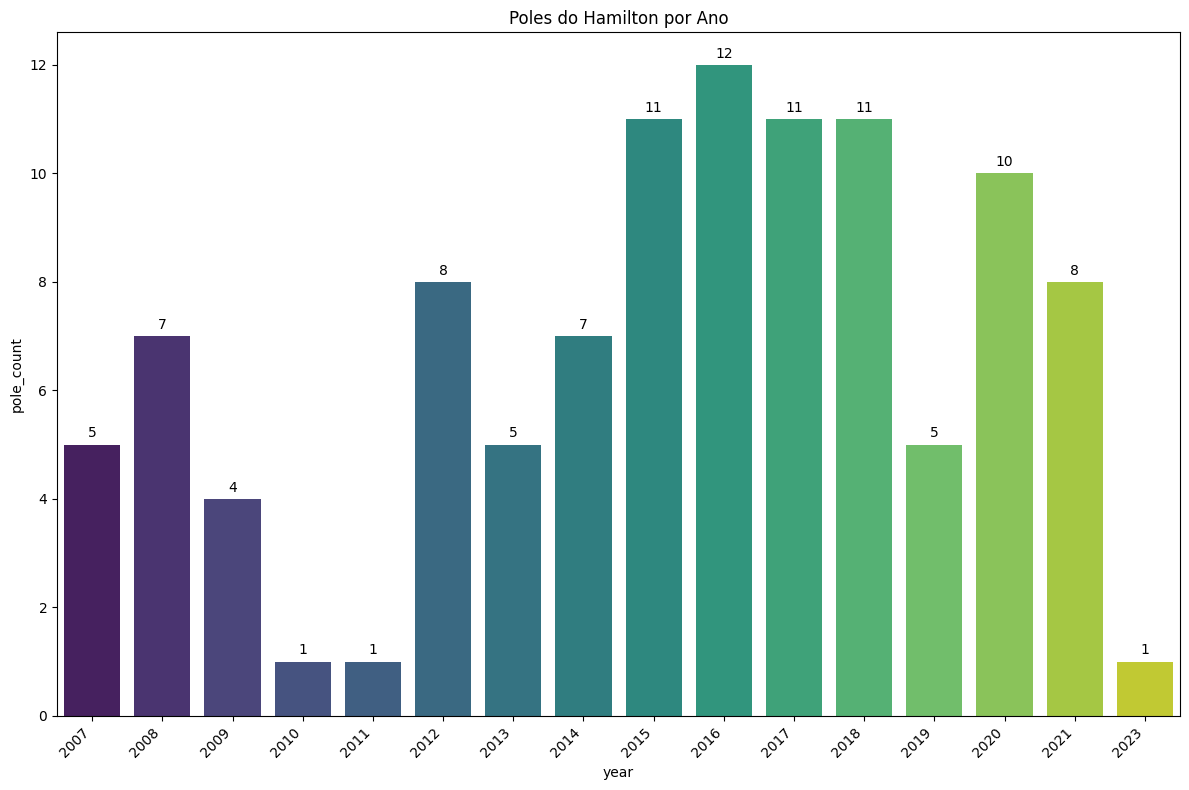

In [17]:
plotter.barplot(
    df=df_poles_ham,
    x="year",                   # eixo X
    groupby="year",              # agrupa por ano
    count_name="pole_count",     # nome da contagem
    palette="viridis",           # paleta de cores
    figsize=(12, 8),
    title="Poles do Hamilton por Ano"
)


Por exemplo, aqui fala que o Hamilton tem 5 poles em 2007, mas em tese deveria ser 6. E o que parece que tá faltando é a pole dele na Hungria.

In [18]:
df_quali[(df_quali["year"] == 2007) & (df_quali["race_name"] == "Hungarian Grand Prix")]

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_nationality,constructor_name,constructor_nationality,position,q1_time,q2_time,q3_time
588,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,ALO,Fernando,Alonso,Spanish,McLaren,British,1,1:20.425,1:19.661,1:19.674
589,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,HAM,Lewis,Hamilton,British,McLaren,British,2,1:19.570,1:19.301,1:19.781
590,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,HEI,Nick,Heidfeld,German,BMW Sauber,German,3,1:20.751,1:20.322,1:20.259
591,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,RAI,Kimi,Räikkönen,Finnish,Ferrari,Italian,4,1:20.435,1:20.107,1:20.410
592,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,ROS,Nico,Rosberg,German,Williams,British,5,1:20.547,1:20.188,1:20.632
593,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,SCH,Ralf,Schumacher,German,Toyota,Japanese,6,1:20.449,1:20.455,1:20.714
594,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,KUB,Robert,Kubica,Polish,BMW Sauber,German,7,1:20.366,1:20.703,1:20.876
595,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,FIS,Giancarlo,Fisichella,Italian,Renault,French,8,1:21.645,1:20.590,1:21.079
596,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,TRU,Jarno,Trulli,Italian,Toyota,Japanese,9,1:20.481,1:19.951,1:21.206
597,Hungarian Grand Prix,2007,2007-08-05,Hungaroring,Hungary,WEB,Mark,Webber,Australian,Red Bull,Austrian,10,1:20.794,1:20.439,1:21.256


Analisando os dados mais a fundo e pesquisando sobre o GP da Hungria: o Hamilton oficialmente fez a pole, porém o que aconteceu foi que o na verdade quem fez o melhor tempo foi o Alonso (conforme os dados mostram corretamente), mas o Alonso foi penalizado e não largou em primeiro na corrida. Então o dataset está correto no sentido de mostrar quem fez os melhores tempos mas não necessariamente vai mostrar quem vai largar em primeiro de fato caso tenha acontecido alguma penalização. Isso potencialmente pode ser corrigido pelo dataset de corridas, que tem a posição de largada de cada piloto.

Ao mesmo tempo, em 2012 ele teria feito 7 poles e não 8, vamos entender:

In [19]:
df_quali_ham_2012 = df_quali_ham[df_quali_ham["year"] == 2012].copy()

In [20]:
df_quali_ham_2012

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_nationality,constructor_name,constructor_nationality,position,q1_time,q2_time,q3_time
4963,Australian Grand Prix,2012,2012-03-18,Albert Park Grand Prix Circuit,Australia,HAM,Lewis,Hamilton,British,McLaren,British,1,1:26.800,1:25.626,1:24.922
4987,Malaysian Grand Prix,2012,2012-03-25,Sepang International Circuit,Malaysia,HAM,Lewis,Hamilton,British,McLaren,British,1,1:37.813,1:37.106,1:36.219
5012,Chinese Grand Prix,2012,2012-04-15,Shanghai International Circuit,China,HAM,Lewis,Hamilton,British,McLaren,British,2,1:36.763,1:35.902,1:35.626
5036,Bahrain Grand Prix,2012,2012-04-22,Bahrain International Circuit,Bahrain,HAM,Lewis,Hamilton,British,McLaren,British,2,1:34.813,1:33.209,1:32.520
5059,Spanish Grand Prix,2012,2012-05-13,Circuit de Barcelona-Catalunya,Spain,HAM,Lewis,Hamilton,British,McLaren,British,1,1:22.583,1:22.465,1:21.707
5086,Monaco Grand Prix,2012,2012-05-27,Circuit de Monaco,Monaco,HAM,Lewis,Hamilton,British,McLaren,British,4,1:16.063,1:15.166,1:14.583
5107,Canadian Grand Prix,2012,2012-06-10,Circuit Gilles Villeneuve,Canada,HAM,Lewis,Hamilton,British,McLaren,British,2,1:14.891,1:14.371,1:14.087
5131,European Grand Prix,2012,2012-06-24,Valencia Street Circuit,Spain,HAM,Lewis,Hamilton,British,McLaren,British,2,1:39.169,1:38.616,1:38.410
5160,British Grand Prix,2012,2012-07-08,Silverstone Circuit,UK,HAM,Lewis,Hamilton,British,McLaren,British,8,1:47.433,1:54.897,1:53.543
5184,German Grand Prix,2012,2012-07-22,Hockenheimring,Germany,HAM,Lewis,Hamilton,British,McLaren,British,8,1:16.221,1:37.365,1:44.186


Analisando os dados e dando uma pesquisada a respeito chego em conclusões parecidas com o que vi acima sobre o GP das Hungria de 2007: em 2012 no GP da Espanha o Hamilton fez a volta mais rápida (como os dados mostram), mas na verdade ele largou de último porque o carro dele estava irregular. Então em termos de analisar os tempos, parece que esse dataset vai estar correto para os dados que estão presentes mas não vai respeitar eventuais desclassificações etc sendo que imagino que isso vai ser respeitado no dataset de corridas (o que faz sentido). Em breve, vou dar uma olhada no dataset de corridas pra confirmar. 

# Dados de Corrida:

In [21]:
df_race = f1_db.run_query_file("data/db_queries/race_results_report.sql").drop_duplicates()

In [22]:
df_race

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_full_name,driver_nationality,...,finishing_position,points_scored,laps_completed,time_in_race,time_in_race_ms,fastest_lap_number,fastest_lap_rank,fastest_lap_time,fastest_lap_speed,race_status
0,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HAM,Lewis,Hamilton,Lewis Hamilton,British,...,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,Finished
1,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,HEI,Nick,Heidfeld,Nick Heidfeld,German,...,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,Finished
2,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,ROS,Nico,Rosberg,Nico Rosberg,German,...,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,Finished
3,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,ALO,Fernando,Alonso,Fernando Alonso,Spanish,...,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,Finished
4,Australian Grand Prix,2008,2008-03-16,Albert Park Grand Prix Circuit,Australia,KOV,Heikki,Kovalainen,Heikki Kovalainen,Finnish,...,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26754,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,MAG,Kevin,Magnussen,Kevin Magnussen,Danish,...,16,0.0,57,\N,\N,57,1,1:25.637,222.002,+1 Lap
26755,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,LAW,Liam,Lawson,Liam Lawson,New Zealander,...,17,0.0,55,\N,\N,52,12,1:28.751,214.212,Engine
26756,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,BOT,Valtteri,Bottas,Valtteri Bottas,Finnish,...,18,0.0,30,\N,\N,14,19,1:29.482,212.462,Collision damage
26757,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,COL,Franco,Colapinto,Franco Colapinto,Argentinian,...,19,0.0,26,\N,\N,5,17,1:29.411,212.631,Engine


b:\projetos\f1_analytics\src\data_viz\plotter.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
b:\projetos\f1_analytics\src\data_viz\plotter.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha=ha)


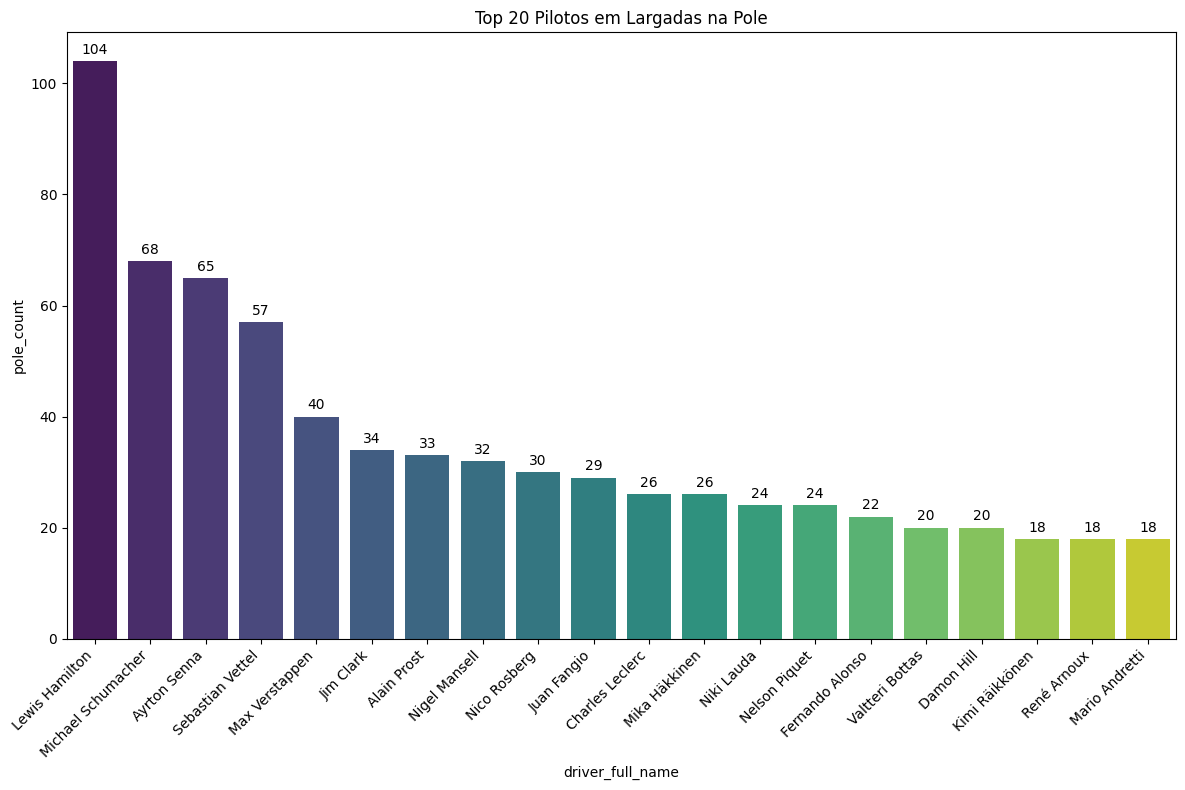

In [23]:
# Vou comparar a as quantidades de poles em relação ao que vimos no dataset de qualificação pra comparar:

plotter.barplot(
    df=df_race,
    x="driver_full_name",                  # eixo X
    filter_query="starting_position == 1", # filtro
    groupby="driver_full_name",            # agrupamento
    count_name="pole_count",               # nome da coluna de contagem
    top_n=20,                              # top 20
    sort_by="pole_count",                  # ordena pela contagem
    ascending=False,                       # do maior pro menor
    palette="viridis",                     # paleta de cores
    figsize=(12, 8),                        # tamanho da figura
    title="Top 20 Pilotos em Largadas na Pole"
)


In [24]:
# A maioria parece certo, mas o Jim Clark tem 1 pole a mais no dataset de corrrida do que ele deveria, vou tentar investigar isso:

df_race_clark = df_race[df_race['driver_full_name'] == "Jim Clark"].copy()

<Axes: title={'center': 'Poles de Jim Clark por Ano'}, xlabel='year'>

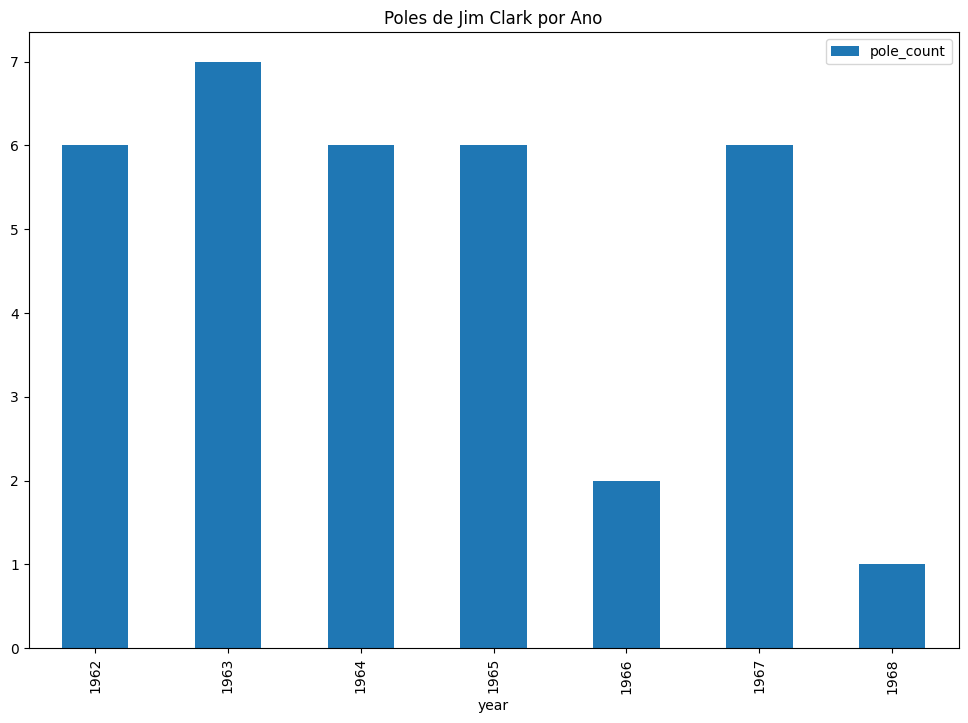

In [25]:
df_race_clark[df_race_clark['starting_position'] == 1].groupby("year").size().reset_index(name="pole_count").plot(kind='bar', x='year', y='pole_count', figsize=(12, 8), title="Poles de Jim Clark por Ano")

In [26]:
# O problema está em 1964

df_race_clark[(df_race_clark['year'] == 1964) & (df_race_clark['starting_position'] == 1)].copy()

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_full_name,driver_nationality,...,finishing_position,points_scored,laps_completed,time_in_race,time_in_race_ms,fastest_lap_number,fastest_lap_rank,fastest_lap_time,fastest_lap_speed,race_status
17191,Monaco Grand Prix,1964,1964-05-10,Circuit de Monaco,Monaco,\N,Jim,Clark,Jim Clark,British,...,4,3.0,96,\N,\N,\N,\N,\N,\N,Engine
17260,French Grand Prix,1964,1964-06-28,Rouen-Les-Essarts,France,\N,Jim,Clark,Jim Clark,British,...,14,0.0,31,\N,\N,\N,\N,\N,\N,Engine
17264,British Grand Prix,1964,1964-07-11,Brands Hatch,UK,\N,Jim,Clark,Jim Clark,British,...,1,9.0,80,2:15:07.0,8107000,\N,\N,\N,\N,Finished
17362,United States Grand Prix,1964,1964-10-04,Watkins Glen,USA,\N,Jim,Clark,Jim Clark,British,...,7,0.0,102,\N,\N,\N,\N,\N,\N,Out of fuel
17379,Mexican Grand Prix,1964,1964-10-25,Autódromo Hermanos Rodríguez,Mexico,\N,Jim,Clark,Jim Clark,British,...,5,2.0,64,\N,\N,\N,\N,\N,\N,Engine
24298,United States Grand Prix,1964,1964-10-04,Watkins Glen,USA,\N,Jim,Clark,Jim Clark,British,...,12,0.0,54,\N,\N,\N,\N,\N,\N,Injection


O Jim Clark, por incrível que pareça, realmente "terminou" essa corrida 2 vezes. O carro dele tava pra quebrar e aí trocaram ele de carro, então ele saiu de um carro e depois o outro quebrou também (risos). De resto, parece até que tá ok. Agora vamos dar uma olhada em vitórias:

b:\projetos\f1_analytics\src\data_viz\plotter.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
b:\projetos\f1_analytics\src\data_viz\plotter.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha=ha)


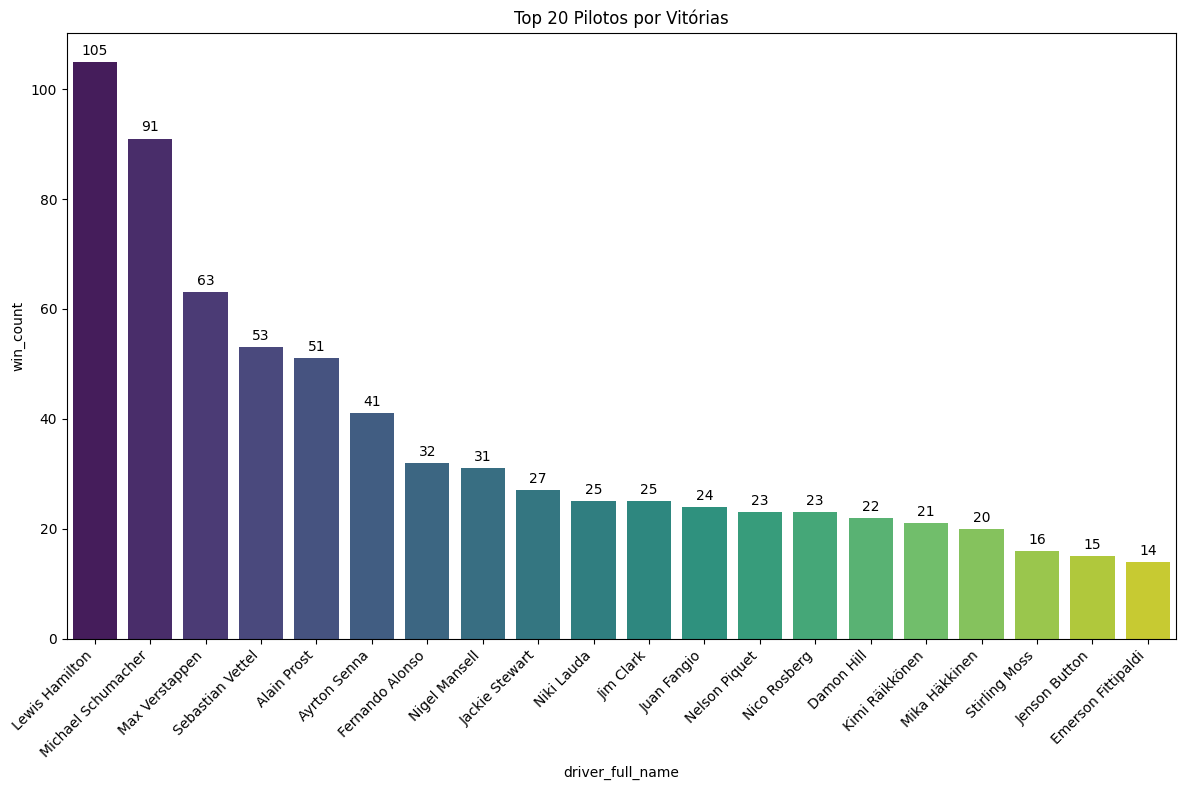

In [27]:
plotter.barplot(
    df_race,
    x="driver_full_name",
    filter_query="finishing_position == 1",
    groupby="driver_full_name",
    count_name="win_count",
    top_n=20,
    sort_by="win_count",
    title="Top 20 Pilotos por Vitórias",
)

Esse dataset está parecendo fazer sentido em relação às quantidades.

Vi no Kaggle um cara falando que tem um erro específico no GP do Japão de 2019 em relação a quem ganhou a corrida. Vamos dar uma olhada:

In [28]:
df_race_jp_2019 = df_race[(df_race['year'] == 2019) & (df_race['race_name'] == "Japanese Grand Prix")].copy()

In [29]:
df_race_jp_2019

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_full_name,driver_nationality,...,finishing_position,points_scored,laps_completed,time_in_race,time_in_race_ms,fastest_lap_number,fastest_lap_rank,fastest_lap_time,fastest_lap_speed,race_status
24520,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,BOT,Valtteri,Bottas,Valtteri Bottas,Finnish,...,1,25.0,52,1:21:46.755,4906755,49,4,1:31.862,227.571,Finished
24521,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,VET,Sebastian,Vettel,Sebastian Vettel,German,...,2,18.0,52,+13.343,4920098,38,5,1:32.122,226.929,Finished
24522,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,HAM,Lewis,Hamilton,Lewis Hamilton,British,...,3,16.0,52,+13.858,4920613,45,1,1:30.983,229.770,Finished
24523,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,ALB,Alexander,Albon,Alexander Albon,Thai,...,4,12.0,52,+59.537,4966292,36,8,1:32.775,225.332,Finished
24524,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,SAI,Carlos,Sainz,Carlos Sainz,Spanish,...,5,10.0,52,+1:09.101,4975856,46,12,1:33.563,223.434,Finished
24525,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,LEC,Charles,Leclerc,Charles Leclerc,Monegasque,...,6,8.0,51,\N,\N,48,2,1:31.611,228.195,+1 Lap
24526,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,GAS,Pierre,Gasly,Pierre Gasly,French,...,7,6.0,51,\N,\N,43,17,1:35.321,219.313,+1 Lap
24527,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,PER,Sergio,Pérez,Sergio Pérez,Mexican,...,8,4.0,51,\N,\N,46,7,1:32.621,225.706,+1 Lap
24528,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,STR,Lance,Stroll,Lance Stroll,Canadian,...,9,2.0,51,\N,\N,26,14,1:34.713,220.721,+1 Lap
24529,Japanese Grand Prix,2019,2019-10-13,Suzuka Circuit,Japan,KVY,Daniil,Kvyat,Daniil Kvyat,Russian,...,10,1.0,51,\N,\N,47,10,1:33.239,224.210,+1 Lap


Devem ter arrumado o dataset, pq parece que o vencedor está correto, realmente foi o Bottas que ganhou essa corrida.

É difícil continuar a validação pq não vou ficar olhando o dataset inteiro com todos os dados em detalhe, mas o que eu vi superficialmente desse dataset de resultados de corrida, eu estou contente e de boa para seguir com ele por ora.

# Dados de tempos de voltas:

In [30]:
df_lap_times = f1_db.run_query_file("data/db_queries/lap_times_report.sql").drop_duplicates()

In [31]:
df_lap_times

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_full_name,driver_nationality,lap_number,position_on_lap,lap_time,lap_time_ms
0,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,VIL,Jacques,Villeneuve,Jacques Villeneuve,Canadian,1,1,1:43.702,103702
1,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Damon,Hill,Damon Hill,British,1,2,1:44.243,104243
2,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Eddie,Irvine,Eddie Irvine,British,1,3,1:44.981,104981
3,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,MSC,Michael,Schumacher,Michael Schumacher,German,1,4,1:45.188,105188
4,Australian Grand Prix,1996,1996-03-10,Albert Park Grand Prix Circuit,Australia,\N,Jean,Alesi,Jean Alesi,French,1,5,1:46.506,106506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589076,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,VER,Max,Verstappen,Max Verstappen,Dutch,58,6,1:28.780,88780
589077,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,GAS,Pierre,Gasly,Pierre Gasly,French,58,7,1:30.865,90865
589078,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,HUL,Nico,Hülkenberg,Nico Hülkenberg,German,58,8,1:30.040,90040
589079,Abu Dhabi Grand Prix,2024,2024-12-08,Yas Marina Circuit,UAE,ALO,Fernando,Alonso,Fernando Alonso,Spanish,58,9,1:28.621,88621


### Tentando ver o quão completo está o dataset:

In [32]:
# Posso ver a quantidade de eventos por ano, pra ter uma ideia geral do quanto e a partir de quando temos mais completude de dados:

df_lap_times_eventos_anos = df_lap_times[['year', 'race_name']].drop_duplicates().sort_values("year")
df_lap_times_eventos_anos

,year,race_name
0,1996,Australian Grand Prix
812,1996,Brazilian Grand Prix
1914,1996,Argentine Grand Prix
3030,1996,European Grand Prix
4135,1996,San Marino Grand Prix
...,...,...
583825,2024,Mexico City Grand Prix
585038,2024,São Paulo Grand Prix
586171,2024,Las Vegas Grand Prix
587109,2024,Qatar Grand Prix


b:\projetos\f1_analytics\src\data_viz\plotter.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x=x, y=y, palette=palette, ax=ax)
b:\projetos\f1_analytics\src\data_viz\plotter.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha=ha)


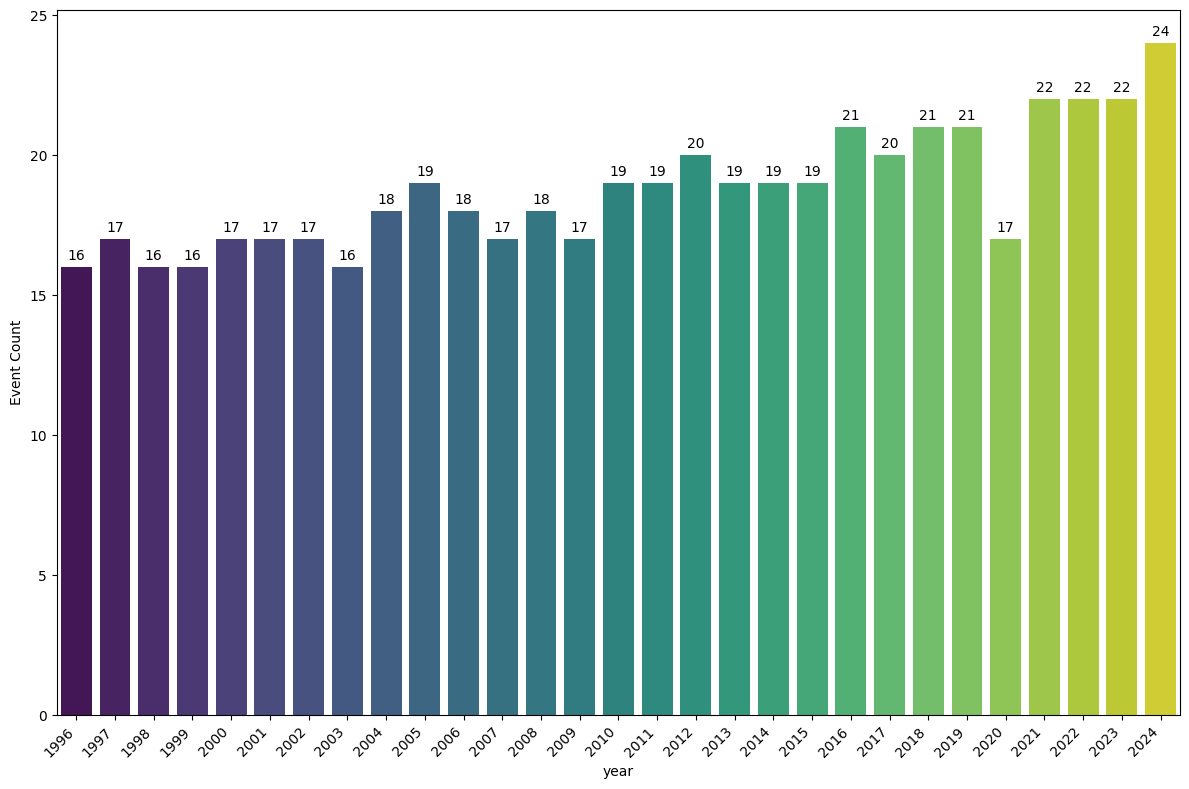

In [33]:
plotter.barplot(
    df_lap_times_eventos_anos,
    x="year",
    groupby="year",
    count_name="Event Count",
    sort_by="year",
)

Dando uma pesquisada geral, parece que tá tudo aqui a partir de 1996.

In [34]:
df_lap_times.sort_values("lap_time", ascending=False)

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_full_name,driver_nationality,lap_number,position_on_lap,lap_time,lap_time_ms
163885,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,43,16,9:45.712,585712
73773,Austrian Grand Prix,2000,2000-07-16,Red Bull Ring,Austria,SCH,Ralf,Schumacher,Ralf Schumacher,German,10,18,9:24.047,564047
541056,Australian Grand Prix,2023,2023-04-02,Albert Park Grand Prix Circuit,Australia,DEV,Nyck,de Vries,Nyck de Vries,Dutch,54,16,9:18.552,558552
532912,Japanese Grand Prix,2022,2022-10-09,Suzuka Circuit,Japan,VER,Max,Verstappen,Max Verstappen,Dutch,3,1,9:13.758,553758
532915,Japanese Grand Prix,2022,2022-10-09,Suzuka Circuit,Japan,OCO,Esteban,Ocon,Esteban Ocon,French,3,4,9:13.288,553288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489803,Sakhir Grand Prix,2020,2020-12-06,Bahrain International Circuit,Bahrain,RUS,George,Russell,George Russell,British,84,11,0:56.499,56499
489658,Sakhir Grand Prix,2020,2020-12-06,Bahrain International Circuit,Bahrain,RUS,George,Russell,George Russell,British,76,2,0:56.442,56442
489641,Sakhir Grand Prix,2020,2020-12-06,Bahrain International Circuit,Bahrain,RUS,George,Russell,George Russell,British,75,2,0:56.393,56393
489787,Sakhir Grand Prix,2020,2020-12-06,Bahrain International Circuit,Bahrain,RUS,George,Russell,George Russell,British,83,12,0:56.319,56319


In [35]:
# Vou olhar o maior tempo de todos pra ver se ele tá faznedo sentido, que é do Massa na Hungria em 2005

df_massa_hungria = fxns.filtrar_evento(
    df_lap_times,
    year=2005,
    circuit="Hungaroring",
    driver_fn="Felipe Massa",
)

In [36]:
df_massa_hungria

,race_name,year,race_date,circuit_name,circuit_country,driver_code,driver_forename,driver_surname,driver_full_name,driver_nationality,lap_number,position_on_lap,lap_time,lap_time_ms
163141,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,1,11,1:39.133,99133
163158,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,2,10,1:26.850,86850
163176,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,3,10,1:25.517,85517
163194,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,4,10,1:25.030,85030
163212,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,5,10,1:24.594,84594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164137,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,59,14,1:23.818,83818
164152,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,60,14,1:23.957,83957
164166,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,61,14,1:23.646,83646
164180,Hungarian Grand Prix,2005,2005-07-31,Hungaroring,Hungary,MAS,Felipe,Massa,Felipe Massa,Brazilian,62,14,1:23.522,83522


Realmente, parece que o Massa teve um problema nessa corrida e ele parou nos boxes na volta 42 pra tentar resovler (no Wikipedia fala que ele passou várias voltas no Box?). Então possivelmente este dado está correto, mas me questiono se faz sentido usá-lo em análises para comparar pilotos etc. Sendo que esses tempos de volta serão sempre totais outliers, quando o piloto teve algum problema.

Mas, para efeito de validação dos dados, vou considerar que o que está aqui, está ok!